# Virtual Scanner 2.0: B0 and B1 map simulation
This notebook use the new Virtual Scanner functionality to include B0 and B1- (B1 Rx) maps in virtual scans.

Installations and imports: 

In [1]:
# Install virtual scanner
!pip install git+https://github.com/imr-framework/virtual-scanner.git@dev

  Cloning https://github.com/imr-framework/virtual-scanner.git (to revision dev) to /tmp/pip-req-build-3rmlmmn9
  Running command git clone -q https://github.com/imr-framework/virtual-scanner.git /tmp/pip-req-build-3rmlmmn9
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
     |████████████████████████████████| 99 kB 4.0 MB/s 
     |████████████████████████████████| 81 kB 6.7 MB/s 
     |████████████████████████████████| 91 kB 7.8 MB/s 
     |████████████████████████████████| 2.1 MB 22.1 MB/s 
     |████████████████████████████████| 2.8 MB 40.7 MB/s 
     |████████████████████████████████| 124 kB 64.8 MB/s 
     |████████████████████████████████| 312 kB 53.4 MB/s 
     |████████████████████████████████| 51 kB 482 kB/s 
     |████████████████████████████████| 59 kB 5.1 MB/s 
     |████████████████████████████████| 89 kB 6.7 MB/s 
     |████████████████████████████████| 87 kB 5.1 MB

In [3]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 92 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
virtual-scanner 1.0.26 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
pypulseq 1.3.1.post1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Import the simulation functions
import matplotlib.pyplot as plt
import virtualscanner.server.simulation.bloch.phantom as pht
from pypulseq.Sequence.sequence import Sequence
import time
import multiprocessing as mp
import virtualscanner.server.simulation.bloch.pulseq_blochsim_methods as blcsim
from google.colab import files
import numpy as np 
from scipy.io import savemat, loadmat

In [4]:
# Grab files
!wget https://raw.githubusercontent.com/imr-framework/virtual-scanner/dev/virtualscanner/notebooks/data/epi_pypulseq_32.seq
!wget https://raw.githubusercontent.com/imr-framework/virtual-scanner/dev/virtualscanner/notebooks/data/b0_map_smaller_Hz.mat
!wget https://raw.githubusercontent.com/imr-framework/virtual-scanner/dev/virtualscanner/notebooks/data/rx_maps_ds_16_32.mat

--2021-11-09 15:37:33--  https://raw.githubusercontent.com/imr-framework/virtual-scanner/dev/virtualscanner/notebooks/data/epi_pypulseq_32.seq
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32889 (32K) [text/plain]
Saving to: ‘epi_pypulseq_32.seq’

epi_pypulseq_32.seq 100%[===================>]  32.12K  --.-KB/s    in 0s      

2021-11-09 15:37:33 (78.0 MB/s) - ‘epi_pypulseq_32.seq’ saved [32889/32889]

--2021-11-09 15:37:33--  https://raw.githubusercontent.com/imr-framework/virtual-scanner/dev/virtualscanner/notebooks/data/b0_map_smaller_Hz.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... c

# Sequence and phantom setup
In this section we load a single-shot EPI sequence (N=32) and make a customizable phantom.

Number of blocks: 66
Number of events:
RF:      1
Gx:     33
Gy:     33
Gz:      2
ADC:     32
Delay:      0
Sequence duration: 0.022190 s
TE: 0.011725 s
TR: 0.022190 s
Flip angle: 90.00 deg
Unique k-space positions (aka cols, rows, etc.): 33 32 1 
Event timing check passed successfully
Max gradient: 1000000 100000 589372 Hz/m == 23.49 2.35 13.84 mT/m
Max slew rate: 5263157895 5000000000 5357927273 Hz/m/s == 123.62 117.44 125.84 mT/m/s
Max absolute gradient: 1000000 Hz/m == 23.49 mT/m
Max absolute slew rate: 8.55799e+09 Hz/m/s == 201.00 T/m/s


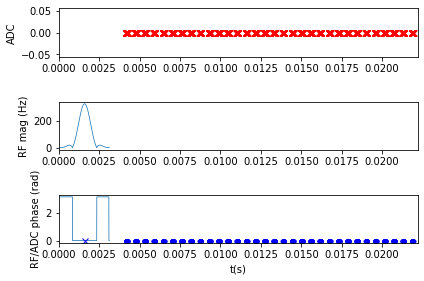

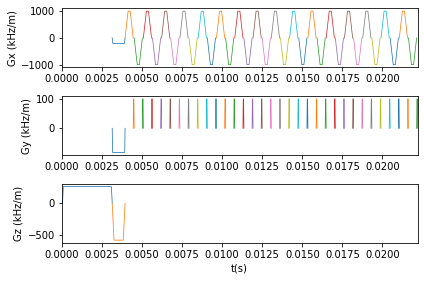

In [5]:
# Make sequence
# For B0: EPI 
# Grab sequence from repo & read it
seq = Sequence()
seq.read('epi_pypulseq_32.seq')
print(seq.test_report())
seq.plot()

<class 'numpy.ndarray'>


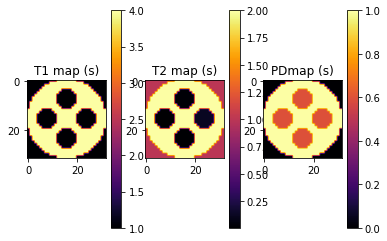

In [6]:
# Make phantom and display
# Phantom size
Npht = 32
FOV = 0.25

# T1, T2 nits are in seconds 
T1T2PD0 = [1,0.5,0.6] # Default values
PDs = [0.5,0.25,0.1] # PD plane's PD values
T1s = [2,1,0.5,0.25] # T1 plane's T1 values
T2s = 0.25*np.array([0.5,0.1,0.05,0.02]) # T2 plane's T2 values 
T1T2PD1 = [4,2,1] # Main cylinder 

# Choose a plane option:  
plane_option = 'T2' 
if plane_option == 'T1':
  p = pht.makeCustomCylindricalPhantom(T1T2PD0, PDs, T1s, T2s, T1T2PD1=T1T2PD1, dim=2, n=Npht, dir='z', loc=0, fov=FOV)
elif plane_option == 'T2':
  p = pht.makeCustomCylindricalPhantom(T1T2PD0, PDs, T1s, T2s, T1T2PD1=T1T2PD1, dim=2, n=Npht, dir='z', loc=-FOV/3, fov=FOV)
  p.loc = (0,0,0)
  p.Zs = [0]
elif plane_option == 'PD':
  p = pht.makeCustomCylindricalPhantom(T1T2PD0, PDs, T1s, T2s, T1T2PD1=T1T2PD1, dim=2, n=Npht, dir='z', loc=FOV/3, fov=FOV)
  p.loc = (0,0,0)
  p.Zs = [0]

# Display phantom
plt.figure(1)
plt.subplot(131)
plt.imshow(np.squeeze(p.T1map),cmap='inferno')
plt.title('T1 map (s)')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.squeeze(p.T2map),cmap='inferno')
plt.title('T2 map (s)')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.squeeze(p.PDmap),cmap='inferno')
plt.title('PDmap (s)')
plt.colorbar()
plt.show()

# B0 simulation

In [7]:
# Set up hardware maps
dfmap = loadmat('b0_map_smaller_Hz.mat')['b0_32_Hz']
dfmap = np.reshape(dfmap,[Npht,Npht,1])
txmap = np.ones((Npht,Npht,1))
rxmap = np.ones((Npht,Npht,1))

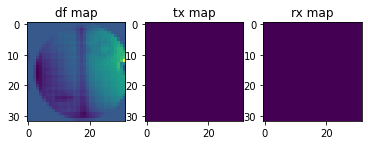

In [8]:
# Show the maps 
plt.subplot(131)
plt.imshow(np.squeeze(dfmap))
plt.title('df map')
plt.subplot(132)
plt.title('tx map')
plt.imshow(np.squeeze(txmap))
plt.subplot(133)
plt.imshow(np.squeeze(np.absolute(rxmap)))
plt.title('rx map')
plt.show()

In [9]:
# Simulate
# Run simulation using multiprocessing
myseq = seq
myphantom = p 

# Time the code: Tic
start_time = time.time()
# Store seq info
seq_info = blcsim.store_pulseq_commands(myseq)
# Get list of locations from phantom
loc_ind_list = myphantom.get_list_inds()
# Initiate multiprocessing pool
pool = mp.Pool(mp.cpu_count())
# Parallel simulation
sg_type = 'Default'


scanner_info = {'B0': dfmap, 'B1tx':txmap, 'B1rx':rxmap}


results = pool.starmap_async(blcsim.sim_single_spingroup_v2,
                              [(loc_ind, myphantom, seq_info, scanner_info, sg_type) for loc_ind in loc_ind_list]).get()
pool.close()
# Add up signal across all SpinGroups
my_signal = np.sum(results, axis=0)
savemat('epi_signals_b0_sim.mat', {'signal':my_signal})

# Time the code: Toc
print("simulated. Time used: %s seconds" % (time.time() - start_time))

# Reconstruct EPI signals 
kspace = my_signal 
print(kspace.shape)
kk = kspace
kk[0::2,:] = kspace[0::2,::-1]
im = np.fft.fftshift(np.fft.ifft2(kk))

savemat('epi_b0.mat',{'imspace':im})
files.download('epi_b0.mat'})

simulated. Time used: 175.96473670005798 seconds
(32, 32)


TypeError: ignored

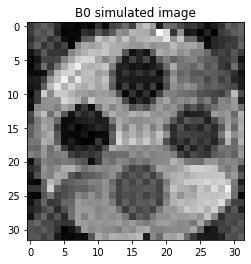

In [11]:
# Show image
plt.imshow(np.absolute(im))
plt.title('B0 simulated image')
plt.gray()

# B1 simulation

In [12]:
# Set up hardware maps
dfmap = np.zeros((Npht,Npht,1))
txmap = np.ones((Npht,Npht,1))

In [14]:
im = np.zeros((32,32,20),dtype='complex')
for c in range(20): # for each channel
  # Pull correct channel from B1 maps
  rxmap = loadmat('rx_maps_ds_16_32.mat')['rx_maps_32_norm'][:,:,c]
  rxmap = np.reshape(rxmap,[Npht,Npht,1])

  # Run simulation using multiprocessing
  myseq = seq
  myphantom = p 

  # Time the code: Tic
  start_time = time.time()
  # Store seq info
  seq_info = blcsim.store_pulseq_commands(myseq)
  # Get list of locations from phantom
  loc_ind_list = myphantom.get_list_inds()
  # Initiate multiprocessing pool
  pool = mp.Pool(mp.cpu_count())
  # Parallel simulation
  sg_type = 'Default'


  scanner_info = {'B0': dfmap, 'B1tx':txmap, 'B1rx':rxmap}


  results = pool.starmap_async(blcsim.sim_single_spingroup_v2,
                                [(loc_ind, myphantom, seq_info, scanner_info, sg_type) for loc_ind in loc_ind_list]).get()
  pool.close()
  # Add up signal across all SpinGroups
  my_signal = np.sum(results, axis=0)
  savemat(f'epi_signals_b1_sim_ch{c+1}.mat', {'signal':my_signal})

  # Time the code: Toc
  print(f"Channel{c+1} simulated. Time used: %s seconds" % (time.time() - start_time))

  # Reconstruct EPI signals 
  kspace = my_signal 
  print(kspace.shape)
  kk = kspace
  kk[0::2,:] = kspace[0::2,::-1]
  im[:,:,c] = np.fft.fftshift(np.fft.ifft2(kk))
  savemat(f'epi_b1_32_ch{c+1}.mat',{'imspace':im[:,:,c]}) 
  #files.download(f'epi_b1_32_ch{c+1}.mat')

savemat('epi_b1_32_all_channels.mat',{'imspace':im})
files.download('epi_b1_32_all_channels.mat')

Channel1 simulated. Time used: 308.0875413417816 seconds
(32, 32)
Channel2 simulated. Time used: 178.45296144485474 seconds
(32, 32)


TypeError: ignored

Text(0.5, 1.0, 'B1 simulated image')

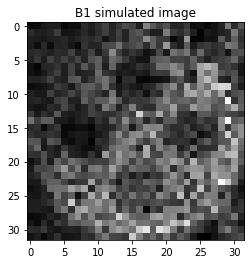

In [15]:
# Combine channels and show image
# Show image
images = np.sqrt(np.sum(np.absolute(im)**2, axis=2))
plt.imshow(np.absolute(images))
plt.title('B1 simulated image')